In [1]:
import os
import keras
import pandas as pd
import hashlib
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras.models import save_model, load_model
import xml.etree.ElementTree as ET
import shutil
import pickle
from pathlib import Path

# # Set the "path_to_dll" variable to the specific directory path containing DLL files.
path_to_dll = 'C:/Users/emmie/anacond3/Lib/site-packages/openslide/openslide-win64-20230414/bin'
os.add_dll_directory(path_to_dll)
import openslide

### Data Preprocessing for Classification Task

- 1) Extract labeled images with the slide image MRXS files and corresponding annotation XML files.
- 2) Store the dictionary object in a pandas dataframe.
- 3) Clean the dataframe to remove classes that contain less than 2 records.
- 4) Split the filtered dataframe into training and validation datasets.
- 5) Save filtered images in the respective dataframes in output directories.

Labeled images are numbered according to their respective class counts, eg. 0,1, 2,...N-1, where N = total class records.
Alternatively, labeled images can be numbered according to their dataframe indices that relate to their positions on the dataframe.

In [15]:
# Extract labeled images from annotated palyslides using MRXS and XML files
# Group the labeled data into 21 subfolders according to their class labels

# MRXS and XML file paths:

mrxs_paths = [
    'C:/Users/emmie/OneDrive/Skrivebord/MasterThesis/PalySlideImages/2_4-C-11 10052.7 ftC = 3064 mC.mrxs',
    'C:/Users/emmie/OneDrive/Skrivebord/MasterThesis/PalySlideImages/2_4-C-11 10070 ftC = 3069.3 mC.mrxs',
    'C:/Users/emmie/OneDrive/Skrivebord/MasterThesis/PalySlideImages/2_7-14 10658ft 8in C.mrxs',
    'C:/Users/emmie/OneDrive/Skrivebord/MasterThesis/PalySlideImages/16_3-2 1998.80 mC.mrxs',
    'C:/Users/emmie/OneDrive/Skrivebord/MasterThesis/PalySlideImages/DigitalSlide_C1M_4S_1.mrxs',
    'C:/Users/emmie/OneDrive/Skrivebord/MasterThesis/PalySlideImages/DigitalSlide_C1M_5S_1.mrxs'
    
]

xml_paths = [
    'C:/Users/emmie/OneDrive/Skrivebord/MasterThesis/PalySlideImages/2_4-C-11 10052.7 ftC = 3064 mC_Annotations.xml',
    'C:/Users/emmie/OneDrive/Skrivebord/MasterThesis/PalySlideImages/2_4-C-11 10070 ftC = 3069.3 mC_Annotations.xml',
    'C:/Users/emmie/OneDrive/Skrivebord/MasterThesis/PalySlideImages/2_7-14 10658ft 8in C_Annotations.xml',
    'C:/Users/emmie/OneDrive/Skrivebord/MasterThesis/PalySlideImages/16_3-2 1998.80 mC_Annotations.xml',
    'C:/Users/emmie/OneDrive/Skrivebord/MasterThesis/PalySlideImages/DigitalSlide_C1M_4S_1_Annotations.xml',
    'C:/Users/emmie/OneDrive/Skrivebord/MasterThesis/PalySlideImages/DigitalSlide_C1M_5S_1_Annotations.xml'                                                                                                                         
]

# Define a function to extract labeled images from MRXS and XML files

def extract_labeled_images(mrxs_path, xml_path):

    slide = openslide.OpenSlide(mrxs_path)

    tree = ET.parse(xml_path)
    root = tree.getroot()

    annotations = root.find('destination/annotations')

    labeled_data = []
    for annotation in annotations:
        name = annotation.get('name')
        type = annotation.get('type')

        polygon_points = annotation.findall('p')
        points = [(int(point.get('x')), int(point.get('y'))) for point in polygon_points]

        # Extract region of interest from MRXS image based on polygon points given in the XML file.
        x_min = min([point[0] for point in points])
        x_max = max([point[0] for point in points])
        y_min = min([point[1] for point in points])
        y_max = max([point[1] for point in points])

        region = slide.read_region((x_min, y_min), 0, (x_max - x_min, y_max - y_min))

        labeled_data.append({'image': region, 'label': name})

    slide.close()

    return labeled_data

# Iterate over the MRXS and XML file paths, extract labeled images, 
# and store the data in a Pandas dataframe
labeled_data_list = []
for mrxs_path, xml_path in zip(mrxs_paths, xml_paths):
    labeled_data = extract_labeled_images(mrxs_path, xml_path)
    labeled_data_list.extend(labeled_data)

data = pd.DataFrame(labeled_data_list)

data['image'] = data['image'].apply(lambda img: img.convert('RGB'))  # Convert to RGBA images to RGB


In [16]:
# Display fist 5 image records in the dataframe.

data.head()

,image,label
0,<PIL.Image.Image image mode=RGB size=401x379 a...,Senoniasphaera inornata
1,<PIL.Image.Image image mode=RGB size=405x345 a...,Senoniasphaera inornata
2,<PIL.Image.Image image mode=RGB size=315x377 a...,Senoniasphaera inornata
3,<PIL.Image.Image image mode=RGB size=458x387 a...,Senoniasphaera inornata
4,<PIL.Image.Image image mode=RGB size=422x373 a...,Senoniasphaera inornata


In [17]:

classes =  sorted(data['label'].unique().tolist())
classes

['Acanthaulax venusta',
 'Chytroeisphaeridia cerastes',
 'Cribroperidinium "prominoseptatum',
 'Cribroperidinium "prominoseptatum"',
 'Cribroperidinium sp.',
 'Danea californica',
 'Dingodinium tuberculosum',
 'Dingodinium tuberosum',
 'Endoscrinium galeritum reticulatum',
 'Fibrocysta axialis',
 'Gonyaulacysta jurassica',
 'Leptodinium mirabile',
 'Palaeoperidinium pyrophorum',
 'Scriniodinium inritibile',
 'Senoniasphaera inornata',
 'Sentusidinium pilosum',
 'Sirmiodinium grossii',
 'Spongodinium delitiense',
 'Spongodinium delitiense (operculum)',
 'Systematophora areolata',
 'Thalassiphora pelagica',
 'Tubotuberella apatela']

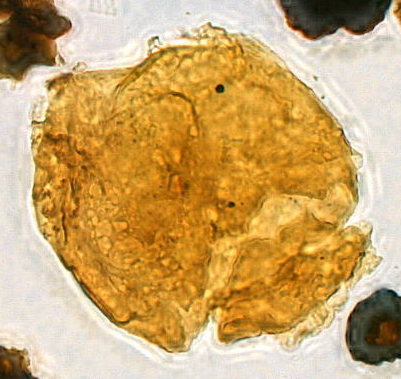

In [19]:
data['image'][0]

In [36]:
data['label'][0]

'Senoniasphaera inornata'

### Split the dataframe into training and validation datasets

In [21]:

# Count the number of records per class
class_counts = data['label'].value_counts()

# Filter out classes with only one record
#filtered_data = data[data['label'].map(class_counts) > 1]
filtered_data = data[data['label'].isin(class_counts[class_counts > 1].index)]

# Get the unique classes
classes = sorted(filtered_data['label'].unique().tolist())

# Split the filtered data into training and validation sets with the same classes
train_data = pd.DataFrame()
val_data = pd.DataFrame()
for label in classes:

    class_data = filtered_data[filtered_data['label'] == label]
    class_train_data, class_val_data = train_test_split(class_data, test_size=0.2, random_state=42)
    train_data = pd.concat([train_data, class_train_data])
    val_data = pd.concat([val_data, class_val_data])

# Get records using using len() function
print("Number of training image data:", len(train_data))

# Get the number of records using the .shape attribute
print("Number of validation image data:", val_data.shape[0])

# Get number of unique class labels
train_num_classes = len(train_data['label'].unique().tolist())
val_num_classes  = len(val_data['label'].unique().tolist())
print(f'Number of training class labels: {train_num_classes}')
print(f'Number of validation class labels: {val_num_classes}')

classes =  train_data['label'].unique().tolist()
classes


Number of training image data: 410
Number of validation image data: 111
Number of training class labels: 13
Number of validation class labels: 13


['Acanthaulax venusta',
 'Cribroperidinium "prominoseptatum"',
 'Dingodinium tuberculosum',
 'Dingodinium tuberosum',
 'Fibrocysta axialis',
 'Gonyaulacysta jurassica',
 'Palaeoperidinium pyrophorum',
 'Senoniasphaera inornata',
 'Sentusidinium pilosum',
 'Spongodinium delitiense',
 'Spongodinium delitiense (operculum)',
 'Systematophora areolata',
 'Tubotuberella apatela']

### Save labeled images as files with unique paths

In [35]:

def save_labeledimages(df, output_dir):

    """
    Save pandas images as files with associated labels linked with the files.

    Args:
    data (dataFrame): Dataframe containing 'image' and 'label' columns.
    output_dir (str): Output directory to save the images.

    """

    # Create the output directory if it does not exist
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Create a dictionary to keep track of the numbering for each class label
    label_count = {}

    # Iterate over the rows of the DataFrame
    for i, row in df.iterrows():
        image = row['image']
        label = row['label']

        # Check if the label exists in the dictionary, if not initialize the count to 0
        if label not in label_count:
            label_count[label] = 0

        # Generate a unique file path for each image based on the label and count
        file_path = os.path.join(output_dir, f"{label}", f"{label_count[label]}.jpg")

        # Replace backslashes with forward slashes in the image path
        file_path = file_path.replace("\\", "/")
        file_path = file_path.replace('"', '')

        # Create the subfolder for the label if it does nt exist
        label_dir = os.path.dirname(file_path)
        if not os.path.exists(label_dir):
            os.makedirs(label_dir)

        # Save the image using the file path
        image.save(file_path)  # The column values should be PIL Image objects

        # If the column values are numpy arrays representing images
        # cv2.imwrite(file_path, image)

        # Print the file path
        #print(f"Image {i+1} saved with label {label}: {file_path}")

        # Increment the count for the current label
        label_count[label] += 1

# Implementation:

# A dataFrame named 'df' contains 'image' and 'label' columns
train_dir = 'C:/Users/emmie/OneDrive/Skrivebord/MasterThesis/ImageClassification/CNN_data/train_data'
val_dir = 'C:/Users/emmie/OneDrive/Skrivebord/MasterThesis/ImageClassification/CNN_data/val_data'
labeled_data_dir = 'C:/Users/emmie/OneDrive/Skrivebord/MasterThesis/ImageClassification/CNN_data/labeled_data'

# Save the images with numbering
save_labeledimages(train_data, train_dir) # Save only training dataset
save_labeledimages(val_data, val_dir)     # Save only validation dataset
save_labeledimages(data, labeled_data_dir) # Save all the images in the dataframe


### Image Classification with CNN

In [2]:
# Import necessary libraries
import os
import re
from natsort import natsorted
import seaborn as sns
import numpy as np
from PIL import Image
import cv2
from sklearn.metrics import f1_score,accuracy_score,classification_report,confusion_matrix 
import matplotlib.pyplot as plt
from keras.models import load_model


2023-07-09 19:27:57.438200: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-09 19:27:57.558782: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-09 19:27:58.030144: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-09 19:27:58.032382: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-09 19:28:01.485538: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

#### Make a prediction

- Predict the class label of an unknown image.

Image resized successfully.
1/1 [==============================] - 0s 109ms/step
Reordered Class Labels:
Index 0: Acanthaulax venusta
Index 1: Cribroperidinium "prominoseptatum"
Index 2: Dingodinium tuberculosum
Index 3: Dingodinium tuberosum
Index 4: Fibrocysta axialis
Index 5: Gonyaulacysta jurassica
Index 6: Palaeoperidinium pyrophorum
Index 7: Senoniasphaera inornata
Index 8: Sentusidinium pilosum
Index 9: Spongodinium delitiense
Index 10: Spongodinium delitiense (operculum)
Index 11: Systematophora areolata
Index 12: Tubotuberella apatela
1/1 [==============================] - 0s 39ms/step
Predicted Class Index: 6
Predicted label: Palaeoperidinium pyrophorum


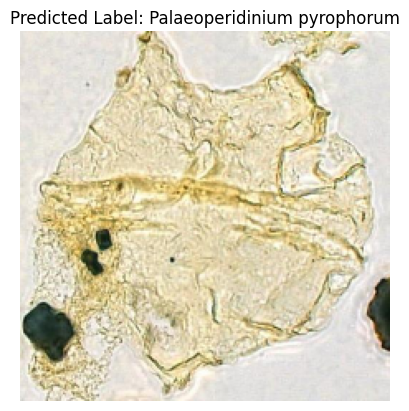

In [4]:

def resize_image(image_path, desired_size):
    try:
        # Check if the image file exists
        if not os.path.exists(image_path):
            print(f"Image file '{image_path}' not found.")
            return None
        
        # Load the image using OpenCV
        image = cv2.imread(image_path)
        
        # Check if the image is loaded successfully
        if image is None:
            print(f"Failed to load image '{image_path}'.")
            return None
        
        # Resize the image
        resized_image = cv2.resize(image, desired_size)
        
        # Convert the resized image to RGB format
        resized_image = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB)
        
        return resized_image
    
    except Exception as e:
        print(f"Error occurred while resizing image '{image_path}': {e}")
        return None

# Specify the path to the image file and the desired size
image_path = '/home/reynel1995/Thesis/images/image14.jpg'
desired_size = (224, 224)  # Example size


# Resize the image
resized_image = resize_image(image_path, desired_size)

# Check if the image was resized successfully
if resized_image is not None:
    # Perform further processing with the resized image
    print("Image resized successfully.")

###########################################################################################
# Load the pre-trained model
model_path = '/home/reynel1995/Thesis/host_1/model.h5'
model = load_model(model_path)

# Get the model's class indices
model_class_indices = model.predict(np.zeros((1, 224, 224, 3))).argmax(axis=1)


# Define the class labels
class_labels = [
    'Acanthaulax venusta',
    'Cribroperidinium "prominoseptatum"',
    'Dingodinium tuberculosum',
    'Dingodinium tuberosum',
    'Fibrocysta axialis',
    'Gonyaulacysta jurassica',
    'Palaeoperidinium pyrophorum',
    'Senoniasphaera inornata',
    'Sentusidinium pilosum',
    'Spongodinium delitiense',
    'Spongodinium delitiense (operculum)',
    'Systematophora areolata',
    'Tubotuberella apatela'
]

# Create a dictionary mapping the model's class indices to the class labels
class_mapping = {index: label for index, label in enumerate(class_labels)}

print("Reordered Class Labels:")
for index, label in class_mapping.items():
    print(f"Index {index}: {label}")


# Preprocess the image
preprocessed_image = np.expand_dims(resized_image, axis=0)
preprocessed_image = preprocessed_image / 255.0  # Normalize pixel values to the range [0, 1]

# Perform the prediction
predictions = model.predict(preprocessed_image)

# Get the predicted class label
predicted_class_index = np.argmax(predictions[0])

# Print the predicted class index
print("Predicted Class Index:", predicted_class_index)

predicted_class_label = class_labels[predicted_class_index]
print(f'Predicted label: {predicted_class_label}')


# Reshape the image array to remove the batch dimension
image_array = np.squeeze(preprocessed_image, axis=0)

# Display the image with the predicted class label
plt.imshow(image_array)
plt.title(f'Predicted Label: {predicted_class_label}')
plt.axis('off')
plt.show()
